# 第5章 参数估计

## 初始化

In [1]:
# 本章需要用到的库
import numpy as np # 导入numpy库
import pandas as pd # 导入pandas库
import matplotlib.pyplot as plt # 导入matplotlib库
import seaborn as sns # 导入seaborn库
import scipy.stats as st # 导入scipy库的stats模块
from scipy.stats import norm, t, chi2, f# 导入正态分布、t分布、卡方分布、F分布
from statsmodels.stats.weightstats import ttest_ind # 导入独立样本t检验

# 设置初始化
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

## 5.1 参数估计的原理

### 5.1.1 点估计与区间估计

重复构造出的100个置信区间中，有5个未包含真值50。


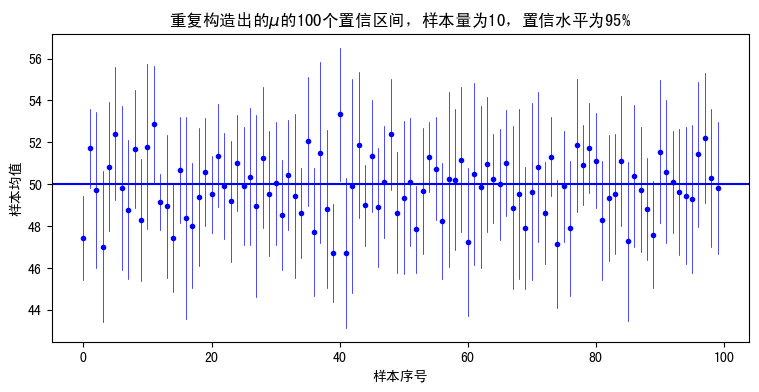

In [2]:
# 置信区间可视化
plt.figure(figsize=(9, 4)) # 设置画布大小

np.random.seed(15) # 设置随机种子，保证可复现性

mu = 50 # 设置均值
sigma = 5 # 设置标准差
count = 0 # 设置计数器
for i in range(100):
    S = np.random.normal(loc=mu, scale=sigma, size=10) # 生成10个样本
    S_mean = np.mean(S) # 计算S的均值
    S_std = np.std(S, ddof=1) # 计算S的标准差
    S_se = S_std/np.sqrt(len(S)) # 计算S的标准误差
    S_ci = norm.interval(0.95, loc=S_mean, scale=S_se) # 计算S的95%置信区间
    if mu < S_ci[0] or mu > S_ci[1]: # 判断置信区间是否包含真值
        count += 1
    plt.plot([i, i], S_ci, color='b', linewidth=0.5) # 绘制置信区间
    plt.plot(i, S_mean, marker='o', color='b', markersize=3) # 绘制样本均值

# 这里只是经过多次模拟恰好选择的一个seed，如果换成其他的seed，结果可能会不同，请不要将此结果作为绝对的结论。
print(f'重复构造出的100个置信区间中，有{count}个未包含真值{mu}。')

plt.axhline(y=mu, color='b', linestyle='-', linewidth=1.5) # 绘制真值
plt.xlabel('样本序号') # 设置x轴标签
plt.ylabel('样本均值') # 设置y轴标签
plt.title('重复构造出的$\mu$的100个置信区间，样本量为10，置信水平为95%') # 设置标题
plt.show() # 显示图形


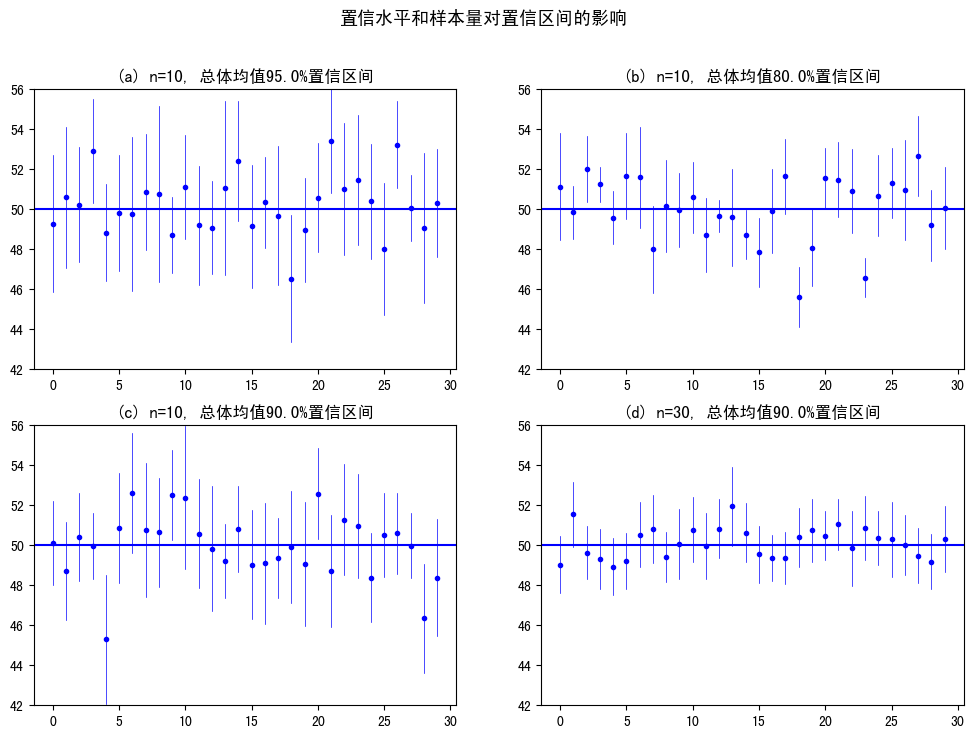

In [3]:
# 置信区间可视化
plt.figure(figsize=(12, 8)) # 设置画布大小

np.random.seed(1234) # 设置随机种子，保证可复现性

mu = 50 # 设置均值
sigma = 5 # 设置标准差
title_i = ['(a)', '(b)', '(c)', '(d)']
n_ls = [10, 10, 10, 30]
conf = [0.95, 0.80, 0.90, 0.90]
for i in range(4):
    plt.subplot(2, 2, i+1)
    for j in range(30):
        S = np.random.normal(loc=mu, scale=sigma, size=n_ls[i]) # 生成n_ls[i]个样本
        S_mean = np.mean(S) # 计算S的均值
        S_std = np.std(S, ddof=1) # 计算S的标准差
        S_se = S_std/np.sqrt(len(S)) # 计算S的标准误差
        S_ci = norm.interval(conf[i], loc=S_mean, scale=S_se) # 计算S的conf[i]置信区间
        plt.plot([j, j], S_ci, color='b', linewidth=0.5) # 绘制置信区间
        plt.plot(j, S_mean, marker='o', color='b', markersize=3) # 绘制样本均值
    plt.axhline(y=mu, color='b', linestyle='-', linewidth=1.5) # 绘制真值
    plt.ylim(42, 56) # 设置y轴范围
    plt.title(f'{title_i[i]} n={n_ls[i]}, 总体均值{conf[i]*100}%置信区间') # 设置标题
plt.suptitle('置信水平和样本量对置信区间的影响', fontsize=13) # 设置总标题
plt.show() # 显示图形

结论：
- 样本量相同时，置信水平越大，置信区间就越宽。
- 置信水平相同时，样本量越大，置信区间就越窄。

### 5.1.2 评估估计量的标准

In [4]:
# 样本均值、样本中位数和样本方差的无偏性模拟
np.random.seed(1234) # 设置随机种子，保证可复现性
x, m, v = [], [], [] # 初始化样本均值、样本中位数和样本方差
n = 10
for i in range(10000):
    d = np.random.normal(loc=50, scale=10, size=n) # 生成n个样本
    x.append(np.mean(d)) # 计算样本均值
    m.append(np.median(d)) # 计算样本中位数
    v.append(np.var(d, ddof=1)) # 计算样本方差
print(f'样本均值的均值：  {np.mean(x):.4f}')
print(f'样本中位数的均值：{np.mean(m):.4f}')
print(f'样本方差的均值：  {np.mean(v):.4f}')

样本均值的均值：  50.0099
样本中位数的均值：49.9710
样本方差的均值：  100.1012


In [5]:
# 样本均值和样本中位数的有效性模拟
np.random.seed(1234) # 设置随机种子，保证可复现性
x, m = [], [] # 初始化样本均值和样本中位数
n = 10
for i in range(10000):
    d = np.random.normal(size=n) # 生成n个样本
    x.append(np.mean(d)) # 计算样本均值
    m.append(np.median(d)) # 计算样本中位数
print(f'样本均值的方差：  {np.var(x, ddof=1):.4f}')
print(f'样本中位数的方差：{np.var(m, ddof=1):.4f}')

样本均值的方差：  0.1004
样本中位数的方差：0.1372


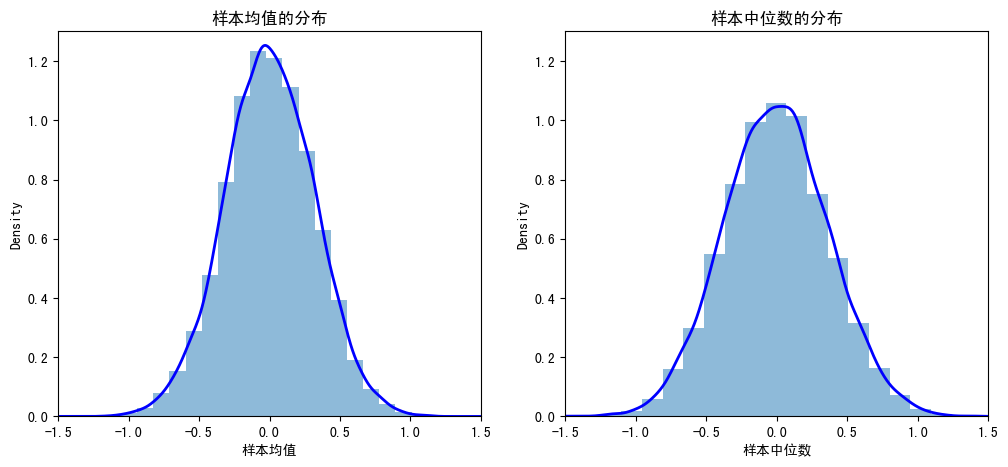

In [6]:
# 绘制样本均值和样本中位数的分布的直方图
def plot_dis(df, ax, xlabel):
    df.plot(kind='hist', bins=20, ax=ax, density=True, alpha=0.5, legend=False)
    df.plot(kind='density', ax=ax, linewidth=2, legend=False, color='b')
    ax.set_ylim(0, 1.3)
    ax.set_xlim(-1.5, 1.5)
    ax.set_xlabel(xlabel)
    ax.set_title(xlabel+'的分布')

plt.subplots(1, 2, figsize=(12, 5)) # 设置画布大小
ax1 = plt.subplot(121) # 绘制第一个子图
plot_dis(pd.DataFrame(x), ax1, '样本均值') # 绘制样本均值的分布
ax2 = plt.subplot(122) # 绘制第二个子图
plot_dis(pd.DataFrame(m), ax2, '样本中位数') # 绘制样本中位数的分布
plt.show() # 显示图形

In [7]:
# 样本均值一致性模拟
# 总体均值和不同样本量的样本均值
np.random.seed(2020) # 设置随机种子，保证可复现性
N = np.random.normal(loc=50, scale=10, size=1000) # 生成1000个样本
mu = np.mean(N) # 计算总体均值

xbar10 = np.mean(np.random.choice(N, 10, replace=False)) # 计算样本均值
xbar100 = np.mean(np.random.choice(N, 100, replace=False)) # 计算样本均值
xbar500 = np.mean(np.random.choice(N, 500, replace=False)) # 计算样本均值
xbar900 = np.mean(np.random.choice(N, 900, replace=False)) # 计算样本均值

pd.DataFrame(
    [mu, xbar10, xbar100, xbar500, xbar900],
    ['总体均值', 'xbar10', 'xbar100', 'xbar500', 'xbar900'],
).T

,总体均值,xbar10,xbar100,xbar500,xbar900
0,49.665586,48.45996,50.165167,49.568964,49.636309


In [8]:
# 样本均值与总体均值mu的差值d
pd.DataFrame([{
        'd10': xbar10 - mu,
        'd100': xbar100 - mu,
        'd500': xbar500 - mu,
        'd900': xbar900 - mu,
}])

,d10,d100,d500,d900
0,-1.205626,0.499581,-0.096622,-0.029277


## 5.2 总体均值的区间估计

### 5.2.1 一个总体均值的估计

In [9]:
# 大样本 n>=30
example5_1 = pd.read_csv('./pydata/chap05/example5_1.csv', encoding='gbk') # 读取数据
example5_1.head() # 显示前5行

,耗油量
0,7.9
1,8.1
2,7.5
3,8.4
4,7.8


In [10]:
interval = norm.interval(0.90, loc=np.mean(example5_1), scale=st.sem(example5_1)) # 计算90%置信区间
np.round(interval, 4) # 保留4位小数

array([[7.8359],
       [8.0991]])

In [11]:
# 小样本 n<30
example5_2 = pd.read_csv('./pydata/chap05/example5_2.csv', encoding='gbk') # 读取数据
example5_2.head() # 显示前5行

,食品重量
0,112.5
1,102.6
2,100.0
3,116.6
4,136.8


In [12]:
interval = st.t.interval(
    0.95, len(example5_2)-1, 
    loc=np.mean(example5_2), scale=st.sem(example5_2)
) # 计算95%置信区间 默认自由度为n, 这里需要减1
np.round(interval, 4) # 保留4位小数

array([[101.3748],
       [109.3452]])

### 5.2.2 两个总体均值差的估计

In [13]:
# 独立大样本
example5_3 = pd.read_csv('./pydata/chap05/example5_3.csv', encoding='gbk') # 读取数据
example5_3.head() # 显示前5行

,男性工资,女性工资
0,7919,5474
1,7556,6475
2,7890,5744
3,8219,6028
4,8778,6420


In [14]:
x1 = example5_3['男性工资']
x2 = example5_3['女性工资']

conf_level = 0.95 # 置信水平

xbar1 = x1.mean() # 计算样本均值
s1 = x1.std() # 计算样本标准差
n1 = len(x1) # 计算样本量

xbar2 = x2.mean() # 计算样本均值
s2 = x2.std() # 计算样本标准差
n2 = len(x2) # 计算样本量

interval = norm.interval(conf_level, loc=(xbar1-xbar2), scale=np.sqrt(s1**2/n1 + s2**2/n2)) # 计算置信区间
print(f'男女平均工资之差的{conf_level*100}%的置信区间：{np.round(interval, 4)}')

男女平均工资之差的95.0%的置信区间：[1826.0516 2212.3984]


In [15]:
# 独立小样本
example5_4 = pd.read_csv('./pydata/chap05/example5_4.csv', encoding='gbk') # 读取数据
example5_4.head() # 显示前5行

,方法一,方法二
0,28.3,27.6
1,30.1,22.2
2,29.0,31.0
3,37.6,33.8
4,32.1,20.0


In [16]:
# 假设总体方差相等
x1 = example5_4['方法一']
x2 = example5_4['方法二']

conf_level = 0.95 # 置信水平
xbar1 = x1.mean() # 计算样本均值
xbar2 = x2.mean() # 计算样本均值

t_value, p_value, df = ttest_ind(x1, x2, alternative='two-sided', usevar='pooled') # 计算t检验的值
interval = t.interval(conf_level, df, loc=(xbar1-xbar2), scale=(xbar1 - xbar2)/t_value) # 计算置信区间
print(f'方法一的平均时间为{xbar1:.2f}, 方法二的平均时间为{xbar2:.2f}')
print(f'假定方差相等, 两方法组装时间差值{conf_level*100}%置信区间为{np.round(interval, 4)}')

方法一的平均时间为32.50, 方法二的平均时间为28.80
假定方差相等, 两方法组装时间差值95.0%置信区间为[0.1403 7.2597]


In [17]:
# 假设总体方差不等
t_value, p_value, df = ttest_ind(x1, x2, alternative='two-sided', usevar='unequal') # 计算t检验的值
interval = t.interval(conf_level, df, loc=(xbar1-xbar2), scale=(xbar1 - xbar2)/t_value) # 计算置信区间
print(f'方法一的平均时间为{xbar1:.2f}, 方法二的平均时间为{xbar2:.2f}')
print(f'假定方差不等, 两方法组装时间差值{conf_level*100}%置信区间为{np.round(interval, 4)}')
print(f'自由度为{df:.4f}')

方法一的平均时间为32.50, 方法二的平均时间为28.80
假定方差不等, 两方法组装时间差值95.0%置信区间为[0.1384 7.2616]
自由度为21.8029


In [18]:
# 配对样本
example5_5 = pd.read_csv('./pydata/chap05/example5_5.csv', encoding='gbk') # 读取数据
example5_5.head() # 显示前5行

,学生编号,试卷A,试卷B,差值d
0,1,78,71,7
1,2,63,44,19
2,3,72,61,11
3,4,89,84,5
4,5,91,74,17


In [19]:
x1 = example5_5['试卷A']
x2 = example5_5['试卷B']
d = x1 - x2

conf_level = 0.95 # 置信水平
dbar = d.mean() # 计算样本均值
sd = d.std() # 计算样本标准差
n = len(d) # 计算样本量

interval = t.interval(conf_level, n-1, loc=dbar, scale=sd/np.sqrt(n)) # 计算置信区间
print(f'两套试卷分数之差的{conf_level*100}%置信区间为：{np.round(interval, 4)}')

两套试卷分数之差的95.0%置信区间为：[ 6.3273 15.6727]


## 5.3 总体比例的区间估计

### 5.3.1 一个总体比例的估计

In [20]:
# 大样本
conf_level = 0.95 # 置信水平
n = 500 # 样本量
x = 325 # 赞成的人数
p = x/n # 样本比例

interval = norm.interval(conf_level, loc=p, scale=np.sqrt(p*(1-p)/n)) # 计算置信区间
print(f'赞成该项改革的人数比例95%置信区间为：{np.round(interval, 4)}')

赞成该项改革的人数比例95%置信区间为：[0.6082 0.6918]


In [21]:
# 任意大小样本（Agresti-Coull方法）
conf_level = 0.95 # 置信水平
n1 = 500 + 4 # 修正后的样本量
p1 = (325+2) / n1 # 修正后的样本比例

interval = norm.interval(conf_level, loc=p1, scale=np.sqrt(p1*(1-p1)/n1)) # 计算置信区间
print(f'赞成该项改革的人数比例95%置信区间为：{np.round(interval, 4)}')

赞成该项改革的人数比例95%置信区间为：[0.6071 0.6905]


### 5.3.2 两个总体比例差的估计

In [22]:
# 大样本
conf_level = 0.95 # 置信水平
n1 = 500 # 样本量
n2 = 400 # 样本量
p1 = 225 / n1 # 样本比例
p2 = 128 / n2 # 样本比例
interval = norm.interval(conf_level, loc=(p1-p2), scale=np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)) # 计算置信区间
print(f'女性与男性收视率差值的95%的置信区间为：{np.round(interval, 4)}')

女性与男性收视率差值的95%的置信区间为：[0.0668 0.1932]


In [23]:
# 任意大小样本（Agresti-Coull方法）
conf_level = 0.95 # 置信水平
n1 = 500 + 2 # 修正后的样本量
n2 = 400 + 2 # 修正后的样本量
p1 = (225+1) / n1 # 修正后的样本比例
p2 = (128+1) / n2 # 修正后的样本比例
interval = norm.interval(conf_level, loc=(p1-p2), scale=np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)) # 计算置信区间
print(f'女性与男性收视率差值的95%的置信区间为：{np.round(interval, 4)}')

女性与男性收视率差值的95%的置信区间为：[0.0662 0.1924]


## 5.4 总体方差的区间估计

### 5.4.1 一个总体方差的估计

In [24]:
example5_2 = pd.read_csv('./pydata/chap05/example5_2.csv', encoding='gbk') # 读取数据
example5_2.head() # 显示前5行

,食品重量
0,112.5
1,102.6
2,100.0
3,116.6
4,136.8


In [25]:
x = example5_2['食品重量']

conf_level = 0.95 # 置信水平
sigma2 = x.var() # 方差
n = len(x) # 样本量

LCI = (n-1) * sigma2 / chi2.ppf(q=(1+conf_level)/2, df=n-1) # 计算置信区间
UCI = (n-1) * sigma2 / chi2.ppf(q=(1-conf_level)/2, df=n-1) # 计算置信区间
print(f'食品重量的方差的{conf_level*100}%置信区间为：[{LCI:.5f}, {UCI:.5f}]')

食品重量的方差的95.0%置信区间为：[56.82897, 180.38811]


### 5.4.2 两个总体方差比的估计

In [26]:
example5_4 = pd.read_csv('./pydata/chap05/example5_4.csv', encoding='gbk') # 读取数据
example5_4.head() # 显示前5行

,方法一,方法二
0,28.3,27.6
1,30.1,22.2
2,29.0,31.0
3,37.6,33.8
4,32.1,20.0


In [27]:
x1 = example5_4['方法一']
x2 = example5_4['方法二']

conf_level = 0.95 # 置信水平
var1 = x1.var() # 计算样本方差
var2 = x2.var() # 计算样本方差
n1 = len(x1) # 计算样本量
n2 = len(x2) # 计算样本量

LCI = (var1 / var2) / f.ppf(q=(1+conf_level)/2, dfn=n1-1, dfd=n2-1) # 计算置信区间
UCI = (var1 / var2) / f.ppf(q=(1-conf_level)/2, dfn=n1-1, dfd=n2-1) # 计算置信区间
print(f'两种方法组装产品所需时间方差比的{conf_level*100}%置信区间为：[{LCI:.5f}, {UCI:.5f}]')

两种方法组装产品所需时间方差比的95.0%置信区间为：[0.23788, 2.87044]


## 习题

### 5.1

In [28]:
df = pd.read_csv('./exercise/chap05/exercise5_1.csv', encoding='gbk') # 读取数据
df.head() # 显示前5行

,上网时间
0,3.3
1,4.4
2,2.1
3,4.7
4,3.1


In [29]:
# 求该校大学生平均上网时间的置信区间，置信水平分别为90%、95%和99%。
x = df['上网时间']

def cal_conf_interval(x, conf_level):
    xbar = x.mean() # 计算样本均值
    s = x.std() # 计算样本标准差
    n = len(x) # 计算样本量
    interval = norm.interval(conf_level, loc=xbar, scale=s/np.sqrt(n)) # 计算置信区间
    print(f'置信水平为{conf_level*100}%的置信区间为：{np.round(interval, 4)}')

cal_conf_interval(x, 0.90) # 计算90%置信区间
cal_conf_interval(x, 0.95) # 计算95%置信区间
cal_conf_interval(x, 0.99) # 计算99%置信区间

置信水平为90.0%的置信区间为：[2.8755 3.7579]
置信水平为95.0%的置信区间为：[2.791  3.8424]
置信水平为99.0%的置信区间为：[2.6258 4.0076]


### 5.2

In [30]:
# 估计总体中赞成采用新设施的户数比例的置信区间，置信水平为95%。
conf_level = 0.95 # 置信水平
n = 50 # 样本量
x = 32 # 赞成的人数
p = x/n # 样本比例

interval = norm.interval(conf_level, loc=p, scale=np.sqrt(p*(1-p)/n)) # 计算置信区间
print(f'赞成采用新设施的户数比例95%置信区间为：{np.round(interval, 4)}')

赞成采用新设施的户数比例95%置信区间为：[0.507 0.773]


In [31]:
# 采用Agresti-Coull区间
conf_level = 0.95 # 置信水平
n = 50 + 4 # 修正后的样本量
x = 32 + 2 # 修正后的赞成的人数
p = x/n # 修正后的样本比例

interval = norm.interval(conf_level, loc=p, scale=np.sqrt(p*(1-p)/n)) # 计算置信区间
print(f'赞成采用新设施的户数比例95%置信区间为：{np.round(interval, 4)}')

赞成采用新设施的户数比例95%置信区间为：[0.5008 0.7584]


### 5.3

In [32]:
df = pd.read_csv('./exercise/chap05/exercise5_3.csv', encoding='gbk') # 读取数据
df

,方式1,方式2
0,6.5,4.2
1,6.6,5.4
2,6.7,5.8
3,6.8,6.2
4,7.1,6.7
5,7.3,7.7
6,7.4,7.7
7,7.7,8.5
8,7.7,9.3
9,10.7,10.0


In [33]:
# (1) 构建第一种排队方式等待时间均值的95%的置信区间。
x = df['方式1']
conf_level = 0.95 # 置信水平
xbar = x.mean() # 计算样本均值
s = x.std() # 计算样本标准差
n = len(x) # 计算样本量
interval = norm.interval(conf_level, loc=xbar, scale=s/np.sqrt(n)) # 计算置信区间
print(f'第一种排队方式等待时间均值95%置信区间为：{np.round(interval, 4)}')

第一种排队方式等待时间均值95%置信区间为：[6.6925 8.2075]


In [34]:
# (2) 构建第二种排队方式等待时间方差的95%的置信区间。
x = df['方式2']
conf_level = 0.95 # 置信水平
var = x.var() # 计算样本方差
n = len(x) # 计算样本量
LCI = (n-1) * var / chi2.ppf(q=(1+conf_level)/2, df=n-1) # 计算置信区间
UCI = (n-1) * var / chi2.ppf(q=(1-conf_level)/2, df=n-1) # 计算置信区间
print(f'第二种排队方式等待时间方差95%置信区间为：[{LCI:.5f}, {UCI:.5f}]')

第二种排队方式等待时间方差95%置信区间为：[1.56996, 11.05952]


In [35]:
# (3) 构建两种方式排队时间均值差值的95%的置信区间：
# 假定总体方差相等
x1 = df['方式1']
x2 = df['方式2']
conf_level = 0.95 # 置信水平
xbar1 = x1.mean() # 计算样本均值
xbar2 = x2.mean() # 计算样本均值

t_value, p_value, dof = ttest_ind(x1, x2, alternative='two-sided', usevar='pooled') # 计算t检验的值
interval = t.interval(conf_level, dof, loc=(xbar1-xbar2), scale=(xbar1 - xbar2)/t_value) # 计算置信区间
print(f'方法一的平均时间为{xbar1:.2f}, 方法二的平均时间为{xbar2:.2f}')
print(f'\n假定方差相等: \n两种方式排队时间均值差值95%置信区间为：{np.round(interval, 4)}')

# 假定总体方差不等
t_value, p_value, dof = ttest_ind(x1, x2, alternative='two-sided', usevar='unequal') # 计算t检验的值
interval = t.interval(conf_level, dof, loc=(xbar1-xbar2), scale=(xbar1 - xbar2)/t_value) # 计算置信区间
print(f'\n假定方差不等: \n两种方式排队时间均值差值95%置信区间为：{np.round(interval, 4)}')
print(f'自由度为{dof:.4f}')

方法一的平均时间为7.45, 方法二的平均时间为7.15

假定方差相等: 
两种方式排队时间均值差值95%置信区间为：[-1.1574  1.7574]

假定方差不等: 
两种方式排队时间均值差值95%置信区间为：[-1.1726  1.7726]
自由度为15.7379


### 5.4

In [36]:
df = pd.read_csv('./exercise/chap05/exercise5_4.csv', encoding='gbk') # 读取数据
df

,人员编号,方法1,方法2
0,1,78,71
1,2,63,44
2,3,72,61
3,4,89,84
4,5,91,74
5,6,49,51
6,7,68,55
7,8,76,60
8,9,85,77
9,10,55,39


In [37]:
# 构建两种方法平均自信心得分之差mud=mu1-mu2的95%的置信区间。
x1 = df['方法1']
x2 = df['方法2']
d = x1 - x2

conf_level = 0.95 # 置信水平
dbar = d.mean() # 计算样本均值
sd = d.std() # 计算样本标准差
n = len(d) # 计算样本量

interval = t.interval(conf_level, n-1, loc=dbar, scale=sd/np.sqrt(n)) # 计算置信区间
print(f'两种方法平均自信心得分之差的95%的置信区间为：{np.round(interval, 4)}')

两种方法平均自信心得分之差的95%的置信区间为：[ 6.3273 15.6727]


### 5.5

In [38]:
n1 = n2 = 250 # 样本量
p1 = 0.4 # 样本比例
p2 = 0.3 # 样本比例

In [39]:
# (1) 求pi1-pi2的90%的置信区间。
conf_level = 0.90 # 置信水平
interval = norm.interval(conf_level, loc=(p1-p2), scale=np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)) # 计算置信区间
print(f'pi1-pi2的90%的置信区间为：{np.round(interval, 4)}')

pi1-pi2的90%的置信区间为：[0.0302 0.1698]


In [40]:
# (2) 求pi1-pi2的95%的置信区间。
conf_level = 0.95 # 置信水平
interval = norm.interval(conf_level, loc=(p1-p2), scale=np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)) # 计算置信区间
print(f'pi1-pi2的95%的置信区间为：{np.round(interval, 4)}')

pi1-pi2的95%的置信区间为：[0.0168 0.1832]


### 5.6

In [41]:
df = pd.read_csv('./exercise/chap05/exercise5_6.csv', encoding='gbk') # 读取数据
df

,机器1,机器2
0,3.45,3.22
1,3.20,3.38
2,3.22,3.30
3,3.50,3.30
4,2.95,3.34
5,3.16,3.28
6,3.20,3.30
7,3.22,3.28
8,2.98,3.19
9,3.75,3.20


In [42]:
# 计算两个总体方差比的95%的置信区间。
x1 = df['机器1']
x2 = df['机器2']

conf_level = 0.95 # 置信水平
var1 = x1.var() # 计算样本方差
var2 = x2.var() # 计算样本方差
n1 = len(x1) # 计算样本量
n2 = len(x2) # 计算样本量

LCI = (var1 / var2) / f.ppf(q=(1+conf_level)/2, dfn=n1-1, dfd=n2-1) # 计算置信区间
UCI = (var1 / var2) / f.ppf(q=(1-conf_level)/2, dfn=n1-1, dfd=n2-1) # 计算置信区间
print(f'两个总体方差比的95%的置信区间为：[{LCI:.5f}, {UCI:.5f}]')

两个总体方差比的95%的置信区间为：[4.05193, 24.61011]
